<a href="https://colab.research.google.com/github/andtab/fbi-most-wanted/blob/main/FBI_Most_Wanted_NLP_Pipeline_ROUGH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FBI Most Wanted Fugitives - Crime Categorization Model**


#**Imports**

In [1]:
# BeautifulSoup is used to extract useful information from the requests
from bs4 import BeautifulSoup

# storing retrieved data in a dataframe
import pandas as pd

# "requests" library is used to send an http request to access information on 
# desired webpages
import requests

# To preserve order of dictionaries used to build dataframes
from collections import OrderedDict, Counter

# "time" library used to add optional sleep in between HTTP GET requests
import time

# Used for file naming of csv output
from datetime import date

In [2]:
# Numpy library for data manipulations additional to what will be accomplished
# using pandas
import numpy as np

In [3]:
# Natural Language Processing Toolkit (NLTK) library used to perform 
# tokenization on the text to be used as features for the model
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score, make_scorer


from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
fbi_df = pd.read_csv('https://raw.githubusercontent.com/andtab/fbi-most-wanted/main/FBI_09162021.csv', index_col = 0)
fbi_df

,Name,Link,Aliases,Reward,Remarks,Caution,Warning Statement,Field Office,Summary,Crime,Date(s) of Birth Used,Place of Birth,Hair,Eyes,Height,Weight,Sex,Race,Occupation,Nationality,Scars and Marks,NCIC,Languages,Build,Complexion,Citizenship,Age
0,JUAN JOSE ESPARRAGOZA-MORENO,https://www.fbi.gov/wanted/cei/juan-jose-espar...,"Juan Jose Esparragoza-Martinez, Jose Luis Espa...","The U.S. Department of State, Bureau for Inter...",Esparragoza-Moreno is believed to have had pla...,The drug trafficking organization led by Juan ...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,El Paso,Conspiracy to Import a Controlled Substance; C...,Criminal Enterprise Investigations,"February 3, 1949","Chuicopa, Sinaloa, Mexico",Black,Brown,"5'8""",200 pounds,Male,White (Hispanic),Unknown,Mexican,None known,W456628782,NaN,NaN,NaN,NaN,NaN
1,JUAN CARLOS MARTINEZ,https://www.fbi.gov/wanted/murders/juan-carlos...,Juan D. Martinez,The FBI is offering a reward for information ...,Martinez speaks fluent English and Spanish. He...,Juan Carlos Martinez is wanted for his alleged...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Birmingham,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"December 2, 1978, December 14, 1981",Mexico,Black,Brown,"5'6""",135 pounds,Male,White (Hispanic),"Welder, Machinist, Metal Fabricator, Interpret...",Mexican,None known,W165633135,NaN,NaN,NaN,NaN,NaN
2,CHRISTOPHER ROBERT METSOS,https://www.fbi.gov/wanted/counterintelligence...,"Christopher R. Metsos, Pavel Kapustin, Gerard ...","The FBI is offering a reward of up to $50,000 ...",Metsos may have fled to Russia. He has travell...,Christopher Robert Metsos is wanted for failin...,SHOULD BE CONSIDERED AN ESCAPE RISK,New York,Conspiracy to Act as an Unregistered Agent of ...,Counterintelligence,"June 16, 1956, April 7, 1954, November 17, 195...",Canada,Light Brown (Balding),Brown,"5'11"" to 6'0""",180 to 195 pounds,Male,White,NaN,Canadian,Metsos has a scar on his chest and burn/pock m...,W560713749,NaN,NaN,NaN,NaN,NaN
3,YURY YEVGENYEVICH SAVIN,https://www.fbi.gov/wanted/counterintelligence...,Yuri Savin,NaN,Savin travels and has traveled to Thailand and...,"Yury Savin and his co-conspirator, Sergey Klin...",NaN,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"January 12, 1975","Moscow, Russia",Brown,Blue,"5'10""",180 pounds,Male,White,"Savin worked for Atrilor LLC in Moscow, which ...",Russian,Savin has a cleft chin.,W026005886,NaN,NaN,NaN,NaN,NaN
4,SERGEY YEVGENYEVICH KLINOV,https://www.fbi.gov/wanted/counterintelligence...,NaN,NaN,"Regarding his appearance, Klinov has long ears...","Sergey Klinov and his co-conspirator, Yury Sav...",NaN,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"February 18, 1968","Tymovskoye, Russia",Balding pattern with a tufted spot on top of h...,Brown,NaN,NaN,Male,White,Klinov is the owner of APEX and Mig Electronic...,Russian,NaN,W196000828,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,JOSE ROSENDO CARRILLO-PADILLA,https://www.fbi.gov/wanted/murders/jose-rosend...,"Jose Carrillo-Padilla, Rosendo Carrillo, Jose ...",NaN,Carrillo-Padilla is known to abuse alcohol. He...,Jose Rosendo Carrillo-Padilla is wanted for hi...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Portland,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"August 15, 1978","Zacatecas, Mexico",Black,Brown,"5'4""",150 pounds,Male,White (Hispanic),Unknown,Mexican,Carrillo-Padilla has tattoos of teardrops on h...,W612612112,NaN,NaN,NaN,NaN,NaN
361,RICHARD AYVAZYAN,https://www.fbi.gov/wanted/wcc/richard-ayvazyan,"Iuliia Zhadko, Richard Avazian, Mark Zindroski...",NaN,"Ayvazyan has previously resided in Topeka, Kan...",Richard Ayvazyan and his co-conspirator (and s...,NaN,Los Angeles,Violation of Pretrial Release,White Collar Crimes,"August 20, 1978, August 2, 1978",Armenia,Black,Brown,"5'10""",190 pounds,Male,White,NaN

##**Eliminate Rows of Data with NaN in the Caution Column**

In [7]:
# Delete any row where "Caution" information is not available
fbi_df = fbi_df[fbi_df['Caution'].notnull()]
fbi_df.reset_index(inplace = True, drop = True)
fbi_df

,Name,Link,Aliases,Reward,Remarks,Caution,Warning Statement,Field Office,Summary,Crime,Date(s) of Birth Used,Place of Birth,Hair,Eyes,Height,Weight,Sex,Race,Occupation,Nationality,Scars and Marks,NCIC,Languages,Build,Complexion,Citizenship,Age
0,JUAN JOSE ESPARRAGOZA-MORENO,https://www.fbi.gov/wanted/cei/juan-jose-espar...,"Juan Jose Esparragoza-Martinez, Jose Luis Espa...","The U.S. Department of State, Bureau for Inter...",Esparragoza-Moreno is believed to have had pla...,The drug trafficking organization led by Juan ...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,El Paso,Conspiracy to Import a Controlled Substance; C...,Criminal Enterprise Investigations,"February 3, 1949","Chuicopa, Sinaloa, Mexico",Black,Brown,"5'8""",200 pounds,Male,White (Hispanic),Unknown,Mexican,None known,W456628782,NaN,NaN,NaN,NaN,NaN
1,JUAN CARLOS MARTINEZ,https://www.fbi.gov/wanted/murders/juan-carlos...,Juan D. Martinez,The FBI is offering a reward for information ...,Martinez speaks fluent English and Spanish. He...,Juan Carlos Martinez is wanted for his alleged...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Birmingham,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"December 2, 1978, December 14, 1981",Mexico,Black,Brown,"5'6""",135 pounds,Male,White (Hispanic),"Welder, Machinist, Metal Fabricator, Interpret...",Mexican,None known,W165633135,NaN,NaN,NaN,NaN,NaN
2,CHRISTOPHER ROBERT METSOS,https://www.fbi.gov/wanted/counterintelligence...,"Christopher R. Metsos, Pavel Kapustin, Gerard ...","The FBI is offering a reward of up to $50,000 ...",Metsos may have fled to Russia. He has travell...,Christopher Robert Metsos is wanted for failin...,SHOULD BE CONSIDERED AN ESCAPE RISK,New York,Conspiracy to Act as an Unregistered Agent of ...,Counterintelligence,"June 16, 1956, April 7, 1954, November 17, 195...",Canada,Light Brown (Balding),Brown,"5'11"" to 6'0""",180 to 195 pounds,Male,White,NaN,Canadian,Metsos has a scar on his chest and burn/pock m...,W560713749,NaN,NaN,NaN,NaN,NaN
3,YURY YEVGENYEVICH SAVIN,https://www.fbi.gov/wanted/counterintelligence...,Yuri Savin,NaN,Savin travels and has traveled to Thailand and...,"Yury Savin and his co-conspirator, Sergey Klin...",NaN,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"January 12, 1975","Moscow, Russia",Brown,Blue,"5'10""",180 pounds,Male,White,"Savin worked for Atrilor LLC in Moscow, which ...",Russian,Savin has a cleft chin.,W026005886,NaN,NaN,NaN,NaN,NaN
4,SERGEY YEVGENYEVICH KLINOV,https://www.fbi.gov/wanted/counterintelligence...,NaN,NaN,"Regarding his appearance, Klinov has long ears...","Sergey Klinov and his co-conspirator, Yury Sav...",NaN,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"February 18, 1968","Tymovskoye, Russia",Balding pattern with a tufted spot on top of h...,Brown,NaN,NaN,Male,White,Klinov is the owner of APEX and Mig Electronic...,Russian,NaN,W196000828,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,JOSE ROSENDO CARRILLO-PADILLA,https://www.fbi.gov/wanted/murders/jose-rosend...,"Jose Carrillo-Padilla, Rosendo Carrillo, Jose ...",NaN,Carrillo-Padilla is known to abuse alcohol. He...,Jose Rosendo Carrillo-Padilla is wanted for hi...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Portland,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"August 15, 1978","Zacatecas, Mexico",Black,Brown,"5'4""",150 pounds,Male,White (Hispanic),Unknown,Mexican,Carrillo-Padilla has tattoos of teardrops on h...,W612612112,NaN,NaN,NaN,NaN,NaN
324,RICHARD AYVAZYAN,https://www.fbi.gov/wanted/wcc/richard-ayvazyan,"Iuliia Zhadko, Richard Avazian, Mark Zindroski...",NaN,"Ayvazyan has previously resided in Topeka, Kan...",Richard Ayvazyan and his co-conspirator (and s...,NaN,Los Angeles,Violation of Pretrial Release,White Collar Crimes,"August 20, 1978, August 2, 1978",Armenia,Black,Brown,"5'10""",190 pounds,Male,White,NaN

#**Tokenization**

In [8]:
# Store the list of stopwords here
stopwords_list = stopwords.words('english')

In [9]:
# Function to generate vocabulary based on ratio of most frequent words to 
# include from each class in the training dataset
def vocabulary_generator(input_array, labels, class_fraction):

  # Extract unique class labels from the training dataset
  classes_array = np.unique(labels)

  # Initialize a counter which will keep track of all the words selected across
  # all classes and their total counts
  total_counter = Counter()

  # Convert the provided fraction of class words into a count of words to
  # include in building the training set
  for idx, class_name in enumerate(classes_array):

    # Build a counter for the words corresponding to each class
    counter = Counter(input_array[labels == class_name].str.split().explode())
    
    # Set count of unique words 
    word_count = len(counter)

    # Convert the fraction of unique words for a class into a count of unique
    # words
    if class_fraction[idx] * word_count == 0:
      features_selected = 0
    
    elif class_fraction[idx] * word_count < 1:
      features_selected = 1

    else:
      features_selected = round(class_fraction[idx] * word_count)

    # Update the total count of most frequent words in each class using the 
    # "update" method
    total_counter.update(Counter(OrderedDict(counter.most_common(n = features_selected))))  

  # After looping through each class, build a list of words to include in the 
  # vocabulary 
  vocabulary = list(OrderedDict(total_counter).keys())

  # Return the vocabulary
  return vocabulary

In [10]:
# Transformer a pandas series of text such that words can be lowercased,
# special characters can be removed, specified stopwords can be removed, and the 
# text can be stemmed or lemmatized 
class TokenizerTransformer(BaseEstimator):
  def __init__(self, lowercase = True, special_character_removal = True, stopword_removal = True, stopwords_list = stopwords_list, stemmer = SnowballStemmer('english'), join_words = True):

    # Store transformation settings as properties of the class' instance
    self.lowercase = lowercase
    self.special_character_removal = special_character_removal
    self.stopword_removal = stopword_removal
    self.stopwords_list = stopwords_list
    self.stemmer = stemmer
    self.join_words = join_words

  # Describe the "fit" method of this class here 


  # def set_params(self, **parameters):
  #   for parameter, value in parameters.items():
  #       setattr(self, parameter, value)
  #   return self


  def fit(self, input_column, y = None, **fit_params):

    return self

  # Describe the "transform" method of this class here 
  def transform(self, input_column, y = None):

    # Apply lowercasing to text if the "lowercase" property is set to "True"
    if self.lowercase:
      input_column = input_column.str.lower()

    # Apply special character removal to text if the property is set to "True"
    if self.special_character_removal:
      input_column = input_column.str.replace('\W', ' ').str.strip()

    # Separate each string of the column into lists of words
    input_column = input_column.str.split()

    # Function to remove stopwords and apply stemming to each list of words 
    # in the input column
    def remove_stopwords(input_text_list, stopword_removal = self.stopword_removal, stopwords_list = self.stopwords_list, stemmer = self.stemmer):

      if stemmer != None:
        remaining_words = [stemmer.stem(word) for word in input_text_list if not word in stopwords_list]
        
      else:
        remaining_words = [word for word in input_text_list if not word in stopwords_list]

      return remaining_words

    # Initialize a list into which cleaned text will be stored
    input_column_clean_list = []

    # Clean each list of words in the column
    if self.stopword_removal: 
      for text in input_column:
        input_column_clean_list.append(remove_stopwords(text))

    else:
      input_column_clean_list = input_column.copy()    

    # Convert the list of lists to a series of lists
    input_column_clean = pd.Series(input_column_clean_list, name = input_column.name)

    # Join each list in the series to create strings
    if self.join_words:
      input_column_clean = input_column_clean.str.join(' ')

    # Return the resulting column
    return input_column_clean

In [11]:
# Transform sparse matrix arising from CountVectorizer to an array
class DenseTransformer():
# TransformerMixin
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [12]:
# Instantiate the label encoder class
le = LabelEncoder()

# Set the features of our model to be the information contained within the 
# "Caution" field of profiles
X = fbi_df['Caution']

# Set the labels of our model to be the category of crime assigned to each 
# label - the following operation transforms the label text into numberical 
# values for each class
y = pd.Series(le.fit_transform(fbi_df['Crime']))

# Perform a train test split using the parameters set below - apply a stratified
# split to counteract prediction issues with class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [13]:
classes_df = pd.DataFrame.from_dict(OrderedDict(Counter(fbi_df['Crime'])), orient = 'index', columns = ['Class Count (Total)'])

classes_df.index.name = 'Crime Label'
# classes_df.sort_values('Class Count (Total)', ascending = False)

In [14]:
def class_counts(class_label_series, count_title, fractional_count_title, index_title):

  classes_df = pd.DataFrame.from_dict(OrderedDict(Counter(class_label_series)), orient = 'index', columns = [count_title])

  classes_df.index.name = 'Crime Label'


  classes_df[fractional_count_title] = classes_df[count_title] / classes_df[count_title].sum()
  return classes_df

In [15]:
classes_df_total = class_counts(fbi_df['Crime'], 'Class Count (Total)', 'Fractional Class Count (Total)', 'Crime Label')
classes_df_train = class_counts(fbi_df.iloc[X_train.index,:]['Crime'], 'Class Count (Train)', 'Fractional Class Count (Train)', 'Crime Label')
classes_df_test = class_counts(fbi_df.iloc[X_test.index,:]['Crime'], 'Class Count (Test)', 'Fractional Class Count (Test)', 'Crime Label')

In [16]:
classes_df = pd.merge(pd.merge(classes_df_total, classes_df_train, left_index = True, right_index = True), classes_df_test, left_index = True, right_index = True)
classes_df.sort_values(by = 'Class Count (Total)', ascending = False)

,Class Count (Total),Fractional Class Count (Total),Class Count (Train),Fractional Class Count (Train),Class Count (Test),Fractional Class Count (Test)
Crime Label,,,,,,
Cyber’s Most Wanted,79,0.240854,63,0.240458,16,0.242424
Violent Crimes - Murders,67,0.204268,54,0.206107,13,0.196970
White Collar Crimes,41,0.125000,33,0.125954,8,0.121212
Criminal Enterprise Investigations,40,0.121951,32,0.122137,8,0.121212
Counterintelligence,40,0.121951,32,0.122137,8,0.121212
Additional Violent Crimes,34,0.103659,27,0.103053,7,0.106061
Crimes Against Children,23,0.070122,18,0.068702,5,0.075758
Human Trafficking,4,0.012195,3,0.011450,1,0.015152


In [17]:
stopwords_additional = ['district', 'united', 'states', \
                        'alleged', 'allegedly', 'arrest', \
                        'unlawful', 'january', 'february', \
                        'march', 'april', 'may', \
                        'june', 'july', 'august', \
                        'september', 'october', 'november', \
                        'december', 'federal']


stopwords_expanded = stopwords_additional + stopwords_list


transformer = TokenizerTransformer(lowercase = True, stopwords_list = stopwords_expanded, stopword_removal = True, stemmer = None, join_words = False)
results_total = Counter()
# transformer.transform(X_train).reset_index(drop = True).apply(results.update)

for class_index in range(0, len(le.classes_)):
  print(le.classes_[class_index])
  class_members_index = (y_train == class_index).index[np.where((y_train == class_index) == True)]

  X_train_class = X_train[class_members_index]

  results = Counter()

  vectorized_counter = np.vectorize(results.update)

  vectorized_counter(transformer.transform(X_train_class).reset_index(drop = True))

  print(results)

Additional Violent Crimes
Counter({'court': 43, 'warrant': 40, 'issued': 39, 'charged': 30, 'california': 25, 'county': 24, 'wanted': 20, 'flight': 17, 'victim': 16, 'robbery': 16, 'vehicle': 15, 'avoid': 14, 'prosecution': 14, 'firearm': 14, 'assault': 13, 'appear': 13, 'state': 13, 'oregon': 13, 'charges': 12, 'degree': 12, 'involvement': 12, 'puerto': 12, 'rico': 12, '2006': 12, 'waller': 12, 'molina': 12, 'neave': 12, 'arrested': 11, 'eastern': 11, 'victory': 11, 'fled': 11, '2017': 10, 'possession': 10, '2019': 10, 'firearms': 10, 'sacramento': 9, 'first': 9, 'attempted': 9, '2007': 9, 'sexual': 8, 'three': 8, 'failed': 8, 'oklahoma': 8, 'police': 8, 'armed': 8, 'officer': 8, 'san': 8, 'vusik': 8, 'weapon': 8, 'counts': 7, 'two': 7, 'jail': 7, 'home': 7, 'shot': 7, '2011': 7, 'clifford': 6, '1998': 6, '2002': 6, 'several': 6, 'felon': 6, '15': 6, 'false': 6, 'barabas': 6, 'extortion': 6, 'rosado': 6, 'car': 6, 'circuit': 6, 'crime': 6, 'felix': 6, 'colorado': 6, 'faure': 6, 'fbi':

In [18]:
X_train

171    On October 19, 2007, a federal grand jury in E...
149    Steven Eugene Clifford is wanted for the alleg...
131    John Dimitrion and his wife, Julieanne, were i...
325    Marietta Terabelian and her co-conspirator (an...
85     Cesar Carlos Castaneda is being sought for mur...
                             ...                        
26     Hamed Ahmed Elbarki, a convicted felon, is wan...
316    Kiya Sadeghi, Alireza Shahvaroghi Farahani, Ma...
56     Noor Aziz Uddin is wanted for his alleged invo...
27     John Anthony Porcaro is wanted for his alleged...
225    Francisco Molina-Neave is being sought for ass...
Name: Caution, Length: 262, dtype: object

In [19]:
frac_words = [0.05] * 5 + [1] + [0.05, 0.05]
vocabulary = vocabulary_generator(X_train, y_train, frac_words)


frac_words2 = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.05, 0.02]

frac_words2 = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

vocabulary2 = vocabulary_generator(X_train, y_train, frac_words2)


# Construct the pipeline
pipe = Pipeline(steps = [('tokenizer', TokenizerTransformer()), \
                         ('vectorizer', CountVectorizer()), \
                          ('sparse_to_dense', DenseTransformer()), \
                          ('model', GaussianNB())])



param_grid = [{ \
        'tokenizer__stemmer': [SnowballStemmer('english'), PorterStemmer(), None],
        'vectorizer__vocabulary': [vocabulary, vocabulary2],
        'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
        'tokenizer__stopword_removal': [True, False],
        'tokenizer__stopwords_list': [stopwords_expanded, stopwords_list]

               }]

gs_pipe = GridSearchCV(estimator = pipe, param_grid= param_grid, cv = 4, scoring = 'f1_macro')
gs_pipe.fit(X_train, y_train)



y_predict_train = gs_pipe.predict(X_train)
y_predict_test = gs_pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


In [20]:
gs_pipe.scorer_

make_scorer(f1_score, pos_label=None, average=macro)

In [21]:
gs_pipe.best_params_['tokenizer__stemmer'] 

In [22]:
gs_pipe.score(X_train, y_train)

0.880707593469687

In [23]:
gs_pipe.score(X_test, y_test)

0.6641522988505748

In [24]:
np.c_[gs_pipe.predict(X_test), y_test]

array([[3, 3],
       [7, 4],
       [4, 4],
       [4, 4],
       [0, 0],
       [6, 0],
       [6, 6],
       [6, 0],
       [7, 7],
       [7, 7],
       [4, 4],
       [0, 6],
       [4, 4],
       [4, 4],
       [0, 0],
       [3, 3],
       [6, 6],
       [1, 1],
       [1, 7],
       [4, 4],
       [6, 6],
       [6, 0],
       [7, 7],
       [3, 3],
       [7, 1],
       [6, 6],
       [4, 4],
       [1, 1],
       [2, 2],
       [4, 4],
       [3, 1],
       [4, 4],
       [4, 4],
       [7, 4],
       [6, 6],
       [7, 7],
       [3, 5],
       [3, 3],
       [6, 6],
       [3, 3],
       [7, 7],
       [6, 6],
       [1, 4],
       [2, 0],
       [2, 2],
       [6, 6],
       [4, 4],
       [1, 1],
       [3, 3],
       [6, 0],
       [1, 1],
       [6, 6],
       [6, 6],
       [4, 4],
       [1, 1],
       [4, 4],
       [6, 6],
       [2, 2],
       [7, 7],
       [1, 1],
       [3, 3],
       [3, 3],
       [6, 6],
       [2, 2],
       [7, 7],
       [6, 2]])

In [25]:
cm_train = pd.DataFrame(confusion_matrix(y_train, y_predict_train), index = le.classes_, columns = le.classes_)
cm_test = pd.DataFrame(confusion_matrix(y_test, y_predict_test), index = le.classes_, columns = le.classes_)

In [26]:
def confusion_matrix_plot_seaborn(confusion_matrix_input, title, scaling_factor = 1, cmap = 'gnuplot2'):

  # Build confusion matrix annotations features which include counts along with
  # their normalization
  cm_row_sums = confusion_matrix_input.sum(axis = 1)
  cm_norm = confusion_matrix_input.div(cm_row_sums, axis = 0)
  cm_text_df = confusion_matrix_input.astype(str) + '\n (' + round(cm_norm, 3).astype(str) + ')'
  cm_text = cm_text_df.to_numpy()

  # Store confusion matrix width/height dimension
  cm_dim = confusion_matrix_input.shape[1]

  # Specify width ratio of the colourbar subplot for clear display in the 
  # final subplot
  width_ratio_colorbar = int(round(cm_dim / 2,0))

  # Initialize figure to include subplots to build the confusions matrix
  cm_fig, axes = plt.subplots(2, 3, gridspec_kw={'width_ratios': [cm_dim, 1, width_ratio_colorbar], 'height_ratios': [cm_dim,1]})

  # Flatten axes to more easily iterate through figure subplots
  axes_flat = axes.flat

  # Apply scaling to the figure based on the specified scaling factor
  height = cm_fig.get_figheight()
  width = cm_fig.get_figwidth()

  cm_fig.set_figheight(height * scaling_factor)
  cm_fig.set_figwidth(width * scaling_factor)

  # Generate the base confusion matrix
  cm = sns.heatmap(confusion_matrix_input, xticklabels = '', cmap = cmap, yticklabels = '', ax = axes_flat[0], annot = cm_text, fmt = '', cbar = False)

  # Title for the figure will be positioned above the base confusion matrix
  cm.title.set_text(title)
  
  # This is the beginning of adding to the base confusion matrix a column with
  # its row totals - build a numpy column vector with the same height dimension 
  # as the confusion matrix, containing the same value in all entries so that
  # the same colour will be set across all values 
  column_colouring = np.full((cm_dim,1), np.max(confusion_matrix_input.values))

  # Annotate the column vector with row totals, calculated here 
  column_annotations = confusion_matrix_input.sum(axis = 1).to_numpy().astype(str).reshape(-1,1)

  # Plot the column of row totals
  totals_column = sns.heatmap(column_colouring, ax= axes_flat[1], annot = column_annotations, cmap = 'Dark2', xticklabels = '', yticklabels = confusion_matrix_input.columns, fmt = '', cbar = False)

  # Set ticks on the right of the column
  totals_column.yaxis.set_ticks_position('right')

  # Set rotation of the ticks and remove the tick marks
  totals_column.tick_params(rotation=0, length=0)

  # Add a colourbar based on the range of values and colourmap of the 
  # base heatmap
  cm_fig.colorbar(axes_flat[0].get_children()[0], ax = axes_flat[2], pad = 0)

  # This is the beginning of adding to the base confusion matrix a row with
  # its column totals - build a numpy row vector with the same width dimension 
  # as the confusion matrix, containing the same value in all entries so that
  # the same colour will be set across all values 
  row_colouring = np.full((1,cm_dim), np.max(cm_test.values))

  # Annotate the row vector with column totals, calculated here 
  row_annotations = confusion_matrix_input.sum(axis = 0).to_numpy().reshape(1,-1)

  # Plot the row of column totals
  totals_row = sns.heatmap(row_colouring, ax= axes_flat[3], annot = row_annotations, fmt = '', cmap = 'Dark2', xticklabels= confusion_matrix_input.columns, yticklabels='', cbar = False)

  # Remove the tick marks
  totals_row.tick_params(length=0)

  # Delete unecessary subplots generate upon figure specification
  cm_fig.delaxes(axes_flat[2])
  cm_fig.delaxes(axes_flat[4])
  cm_fig.delaxes(axes_flat[5])

  #Remove horizontal and vertical spacing between subplots within the figure
  cm_fig.subplots_adjust(wspace=0, hspace=0)



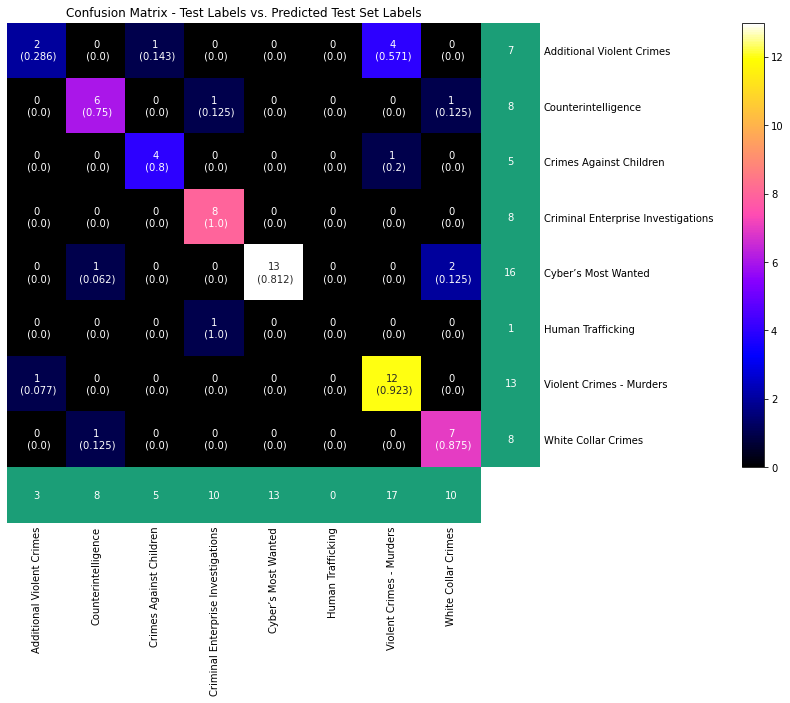

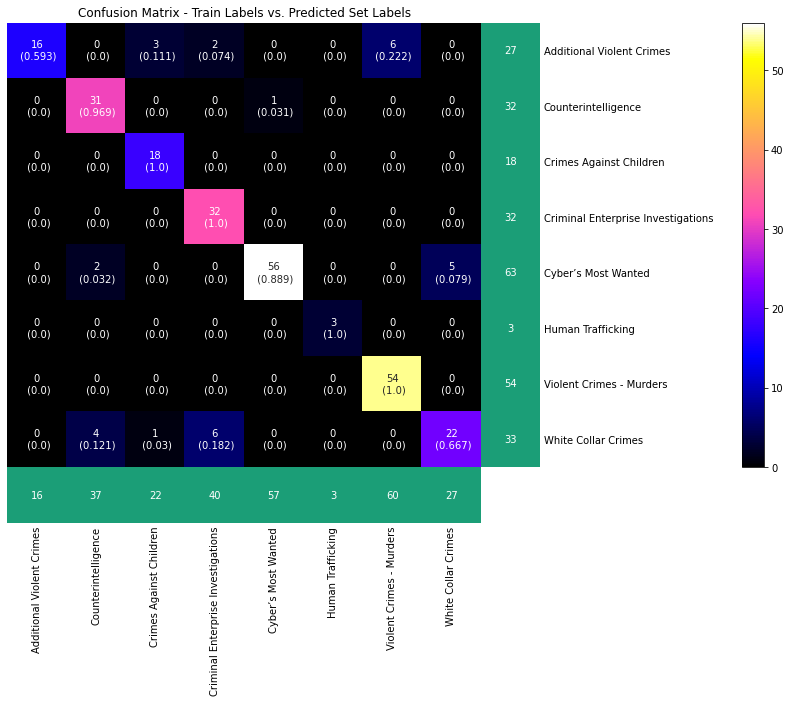

In [27]:
# Plot the confusion matrix to compare classification performance between
# labelling predictions made by model and actual labelling, for both the train
# and test sets

# Confusion Matrix - test data predictions
confusion_matrix_plot_seaborn(cm_test, title = 'Confusion Matrix - Test Labels vs. Predicted Test Set Labels', scaling_factor = 2.3, cmap = 'gnuplot2')

# Confusion Matrix - train data predictions
confusion_matrix_plot_seaborn(cm_train, title = 'Confusion Matrix - Train Labels vs. Predicted Set Labels', scaling_factor = 2.3, cmap = 'gnuplot2')
